<a href="https://colab.research.google.com/github/fahimabrar/Natural-Language-Processing/blob/main/Multiclass%2520Classification%2520of%2520TextToxic_Comment_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

In [1]:
from __future__ import print_function, division
from builtins import range

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
# maximum size for an input/comment/sentence/line 
MAX_VOCAB_SIZE = 20000
# max vocab size is 20000 selected, If there are more than 20000 unique words in the dataset it will be truncated automatically by keras
EMBEDDING_DIM = 200
# we will use gloVe pretrained embeddings, the dimension is 200
VALIDATION_SPLIT = 0.2
# 20 percent data is selected for validating the model

In [4]:
glove_path = '/content/drive/My Drive/Flickr8k_Dataset/'
data_path = '/content/drive/My Drive/NLP/Toxic_comment/'

# path is defined for both the data and the gloVe embeddings

In [5]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
# reading the text file
for line in f:
    values = line.split()
    #spliting each embeddings into tokens/vector values
    word = values[0]
    # on gloVe embeddings in each line the first value is the word itself
    coefs = np.asarray(values[1:], dtype='float32')
    # and the rest of the values are the vector values
    embeddings_index[word] = coefs
    # entering the values in dictionaries, where the word is the key and the embeddings/vector is the value

In [6]:
len(embeddings_index)
# on glove 6B.200d version it has embeddings for 400000 words

400000

In [7]:
train_data =  pd.read_csv(data_path + "train.csv/train.csv")
test_data = pd.read_csv(data_path + "test.csv/test.csv")
test_labels = pd.read_csv(data_path + "test_labels.csv/test_labels.csv")
# reading the train and test files 

In [8]:
train_data.head()
# to see the structures of the data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
train_data.shape

(159571, 8)

# Checking for null values

In [10]:
train_data.isna().any().any()
# so there is no null values

False

In [11]:
targets = train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
# the target/y/dependant values

In [12]:
targets.shape

(159571, 6)

In [13]:
sentences = train_data['comment_text'].values
# the input/x/independent values

In [14]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)

In [16]:
len(tokenizer.word_index)
# In train sentences we have 210337 unique words

210337

### converting words to sequence of numbers based on word index

In [17]:
sequences = tokenizer.texts_to_sequences(sentences)

In [18]:
type(sequences)

list

In [19]:
#sequences[0]
# word sequence for the first comment in the train dataset

In [20]:
max(len(s) for s in sequences)
# maxumul length of a single comment

1400

In [21]:
min(len(s) for s in sequences)
# minimum length of a single comment

0

In [22]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# in keras the sentenc are pre padded and pre truncated
# padding is basically replacing the empty positions with zeros
# e.g  a senntence has only 5 words, here we selected maxumu sequence length is 100. 
# So the first 95 values will be zeoros and the last 5 values will be gahtered from the word index dictionary

# Truncating means if the sentence/comment contains more than 100 words/sequence the extra wors will be removed from the beginig of the sentnece/comments


In [23]:
data[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,   688,
          75,     1,   126,   130,   177,    29,   672,  4511, 12052,
        1116,    86,   331,    51,  2278, 11448,    50,  6864,    15,
          60,  2756,   148,     7,  2937,    34,   117,  1221, 15190,
        2825,     4,    45,    59,   244,     1,   365,    31,     1,
          38,    27,   143,    73,  3462,    89,  3085,  4583,  2273,
         985], dtype=int32)

In [24]:
num_words = 20000
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  if i < 20000:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [25]:
embedding_matrix.shape

(20000, 200)

In [26]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

# we made trainalbe false as we are using pretrained weights from GloVe embeddings

In [27]:
# defining the model woth keras functional API
input = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input)
x = Conv1D(128, 7, activation='relu')(x)
# here filters = 128 and kernel_size = 7
x = MaxPooling1D(3)(x)
x = Conv1D(128, 7, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 7, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(6, activation='sigmoid')(x)

model = Model(input, output)

In [28]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [30]:
BATCH_SIZE = 128
# arbritary selected
EPOCHS = 3
# arbritary selected

r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Epoch 1/3
998/998 [==============================] - 283s 282ms/step - loss: 0.0926 - accuracy: 0.9750 - val_loss: 0.0826 - val_accuracy: 0.9940
Epoch 2/3
998/998 [==============================] - 281s 281ms/step - loss: 0.0754 - accuracy: 0.9893 - val_loss: 0.1000 - val_accuracy: 0.9941
Epoch 3/3
998/998 [==============================] - 281s 282ms/step - loss: 0.0703 - accuracy: 0.9873 - val_loss: 0.0889 - val_accuracy: 0.9941


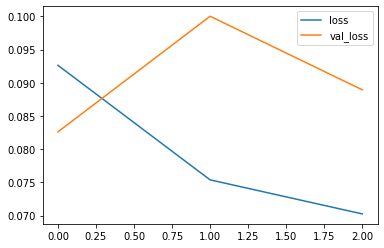

In [31]:

# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

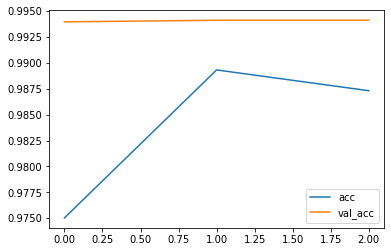

In [32]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()